## Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier

from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, classification_report, mean_squared_error, f1_score, accuracy_score, precision_score




In [27]:


data = pd.read_csv('preprocessed_data.csv')
data_no_encoding = pd.read_csv('preprocessed_data_no_categorical_encoding.csv')

y = data['Attrition']

X = data.drop('Attrition', axis = 1 )
X_no_encoding = data_no_encoding.drop('Attrition', axis = 1)

X_train , X_test, y_train, y_test = train_test_split(X, y , train_size= 0.75, random_state=42, stratify = y)
#we make sure to do a stratified sampling because of the imbalanced dataset
#Stratification does NOT fix imbalance, it only preserves it.
X_no_encoding_train = X_no_encoding.loc[X_train.index]
X_no_encoding_test = X_no_encoding.loc[X_test.index]



print(f'the size of the training dataset is {X_train.shape}, and the test one is {X_test.shape}')

print(f'percentage of attrition in Training is {100 * len(y_train[y_train==1])/len(y_train)}% and in test {100 * len(y_test[y_test==1])/len(y_test)}% ')

the size of the training dataset is (1102, 40), and the test one is (368, 40)
percentage of attrition in Training is 16.1524500907441% and in test 16.032608695652176% 


In [28]:
categorical_cols = ['BusinessTravel','Education','EnvironmentSatisfaction','JobInvolvement',
                'JobLevel','JobSatisfaction','PerformanceRating','RelationshipSatisfaction',
                'StockOptionLevel','WorkLifeBalance', 'Department','EducationField','Gender',
                'JobRole','MaritalStatus','OverTime']

set(categorical_cols) <= set(X_no_encoding.columns) # simple verification that the ensemble of ordinal and nominal columns are actually present in the dataframe

True

## Models

We will go through a lot of models of classification, and organize the results in a dataFrame.

For each model we'll try to retrieve as much info as possible.

All models has be evaluated on the same data splits so comparisons are fair.

The nexxt step after splitting data between training and test is to understand how each model behaves.

This will be done by validation on the training data only first


In [29]:
results = pd.DataFrame(columns=['Mean_AUC','Mean_F1','Mean_Precision','Mean_Recall', 'Mean_Accuracy'])

scoring = {
    "auc": "roc_auc",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
    "accuracy": "accuracy"
}

In [30]:

cv  = StratifiedKFold(n_splits = 5 , shuffle= True , random_state= 425)
#shuffle is true so data is shuffled before split and to protect in case data were ordered somehow by classes


In [31]:
def crossValidate(model_name, model, X_train, y_train, cross_info):

    cv_results = cross_validate(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=cross_info,
        scoring=scoring,
    )

    aggregated_metrics = [value.mean() for (key, value) in cv_results.items()]
    results.loc[model_name] = aggregated_metrics[2:] # the first two values in the list corresponds to fit_time and score_time

"""
In logistic regression :
    C = 1/λ (where λ is the regularization strength)
    Inverse relationship: Smaller C means stronger regularization, larger C means weaker regularization
"""

models = {
    'simple_logistic_regression' : LogisticRegression(C= np.inf, max_iter=1000, random_state=42),
    'logistic_regression_lasso' : LogisticRegression(l1_ratio= 1 ,solver = 'liblinear', C = 1 , max_iter=1000, random_state=42), #the default solver lbfgs doesn't support l1 penalty
    'logistic_regression_ridge' : LogisticRegression(l1_ratio= 0 , C = 1, max_iter=1000, random_state=42),
    'logistic_elastic_net' :  LogisticRegression(l1_ratio=0.5, solver = 'saga', C=1,  max_iter= 1000, random_state=42), # only saga supports elasticnet
    'K nearest neighbors' : KNeighborsClassifier(n_neighbors=7, weights ='distance'), #weights to distance to closer neighbors has more important vote than further ones
    'SVM_gaussian_kernel' : SVC(kernel ='rbf', random_state=42),
    'SVM_polynomial_kernel' : SVC(kernel='poly',random_state=42),
    'SVM_linear_kernel' : SVC(kernel='linear',random_state=42),
    'Decion_tree_gini' : DecisionTreeClassifier(criterion='gini', random_state=17), #gini impurity as criterion of purity in each node
    'Decision_tree_entropy' :  DecisionTreeClassifier(criterion='entropy', random_state=17), #normally we shouldn't expect much difference but both of them are very instable anyway
    'Random Forest' : RandomForestClassifier(random_state = 690),
    'GradientBoosting' : GradientBoostingClassifier(loss = 'log_loss', n_estimators= 150, max_depth = 5),
    'XGBoost' : XGBRFClassifier(),
    'lightGBM' : LGBMClassifier(),
        }

# TODO I would have loved to use catboost as well because it can deal with datasets like plug and play
# catboost can use categorical features without encoding , trees use subset of modalities when splitting
# but unfortunatly there a version conflict causing the dollowing error : 'CatBoostClassifier' object has no attribute '__sklearn_tags__'

In [32]:

for model_name , model in models.items() :
    crossValidate(model_name, 
                  model, 
                  X_train, 
                  y_train, 
                  cv)
    


/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1170: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1170: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1170: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1170: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1170: UserWarning: Setting penalty=None will

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 142, number of negative: 739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 881, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161180 -> initscore=-1.649471
[LightGBM] [Info] Start training from score -1.649471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 142, number of negative: 739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remov

The table we can see above resumes the performance of each model via a cross validation of 5 splits

However this was done to give us an idea on the performance of each model and in no case reflects the full abilities of the models that were tested as:

    No HyperParameter tuning or Gridsearch was done to find the optimal parameters 

    Models haven't been tested on the test observations yet 

We'll class the models based on eachmetric and dive deep into the models depending on the metric we care more about 

In [33]:
results

,Mean_AUC,Mean_F1,Mean_Precision,Mean_Recall,Mean_Accuracy
simple_logistic_regression,0.845945,0.597337,0.740985,0.506825,0.890243
logistic_regression_lasso,0.847598,0.584464,0.766090,0.478889,0.891148
logistic_regression_ridge,0.847781,0.584744,0.771537,0.479206,0.892061
logistic_elastic_net,0.847624,0.576249,0.765281,0.467619,0.890239
K nearest neighbors,0.729879,0.242328,0.783636,0.146984,0.856639
SVM_gaussian_kernel,0.849805,0.268713,0.842778,0.163492,0.859362
SVM_polynomial_kernel,0.841771,0.402881,0.891414,0.269841,0.875673
SVM_linear_kernel,0.845566,0.574598,0.722358,0.484762,0.886610
Decion_tree_gini,0.592436,0.316203,0.303828,0.332063,0.768601
Decision_tree_entropy,0.593012,0.310356,0.328807,0.303968,0.788573


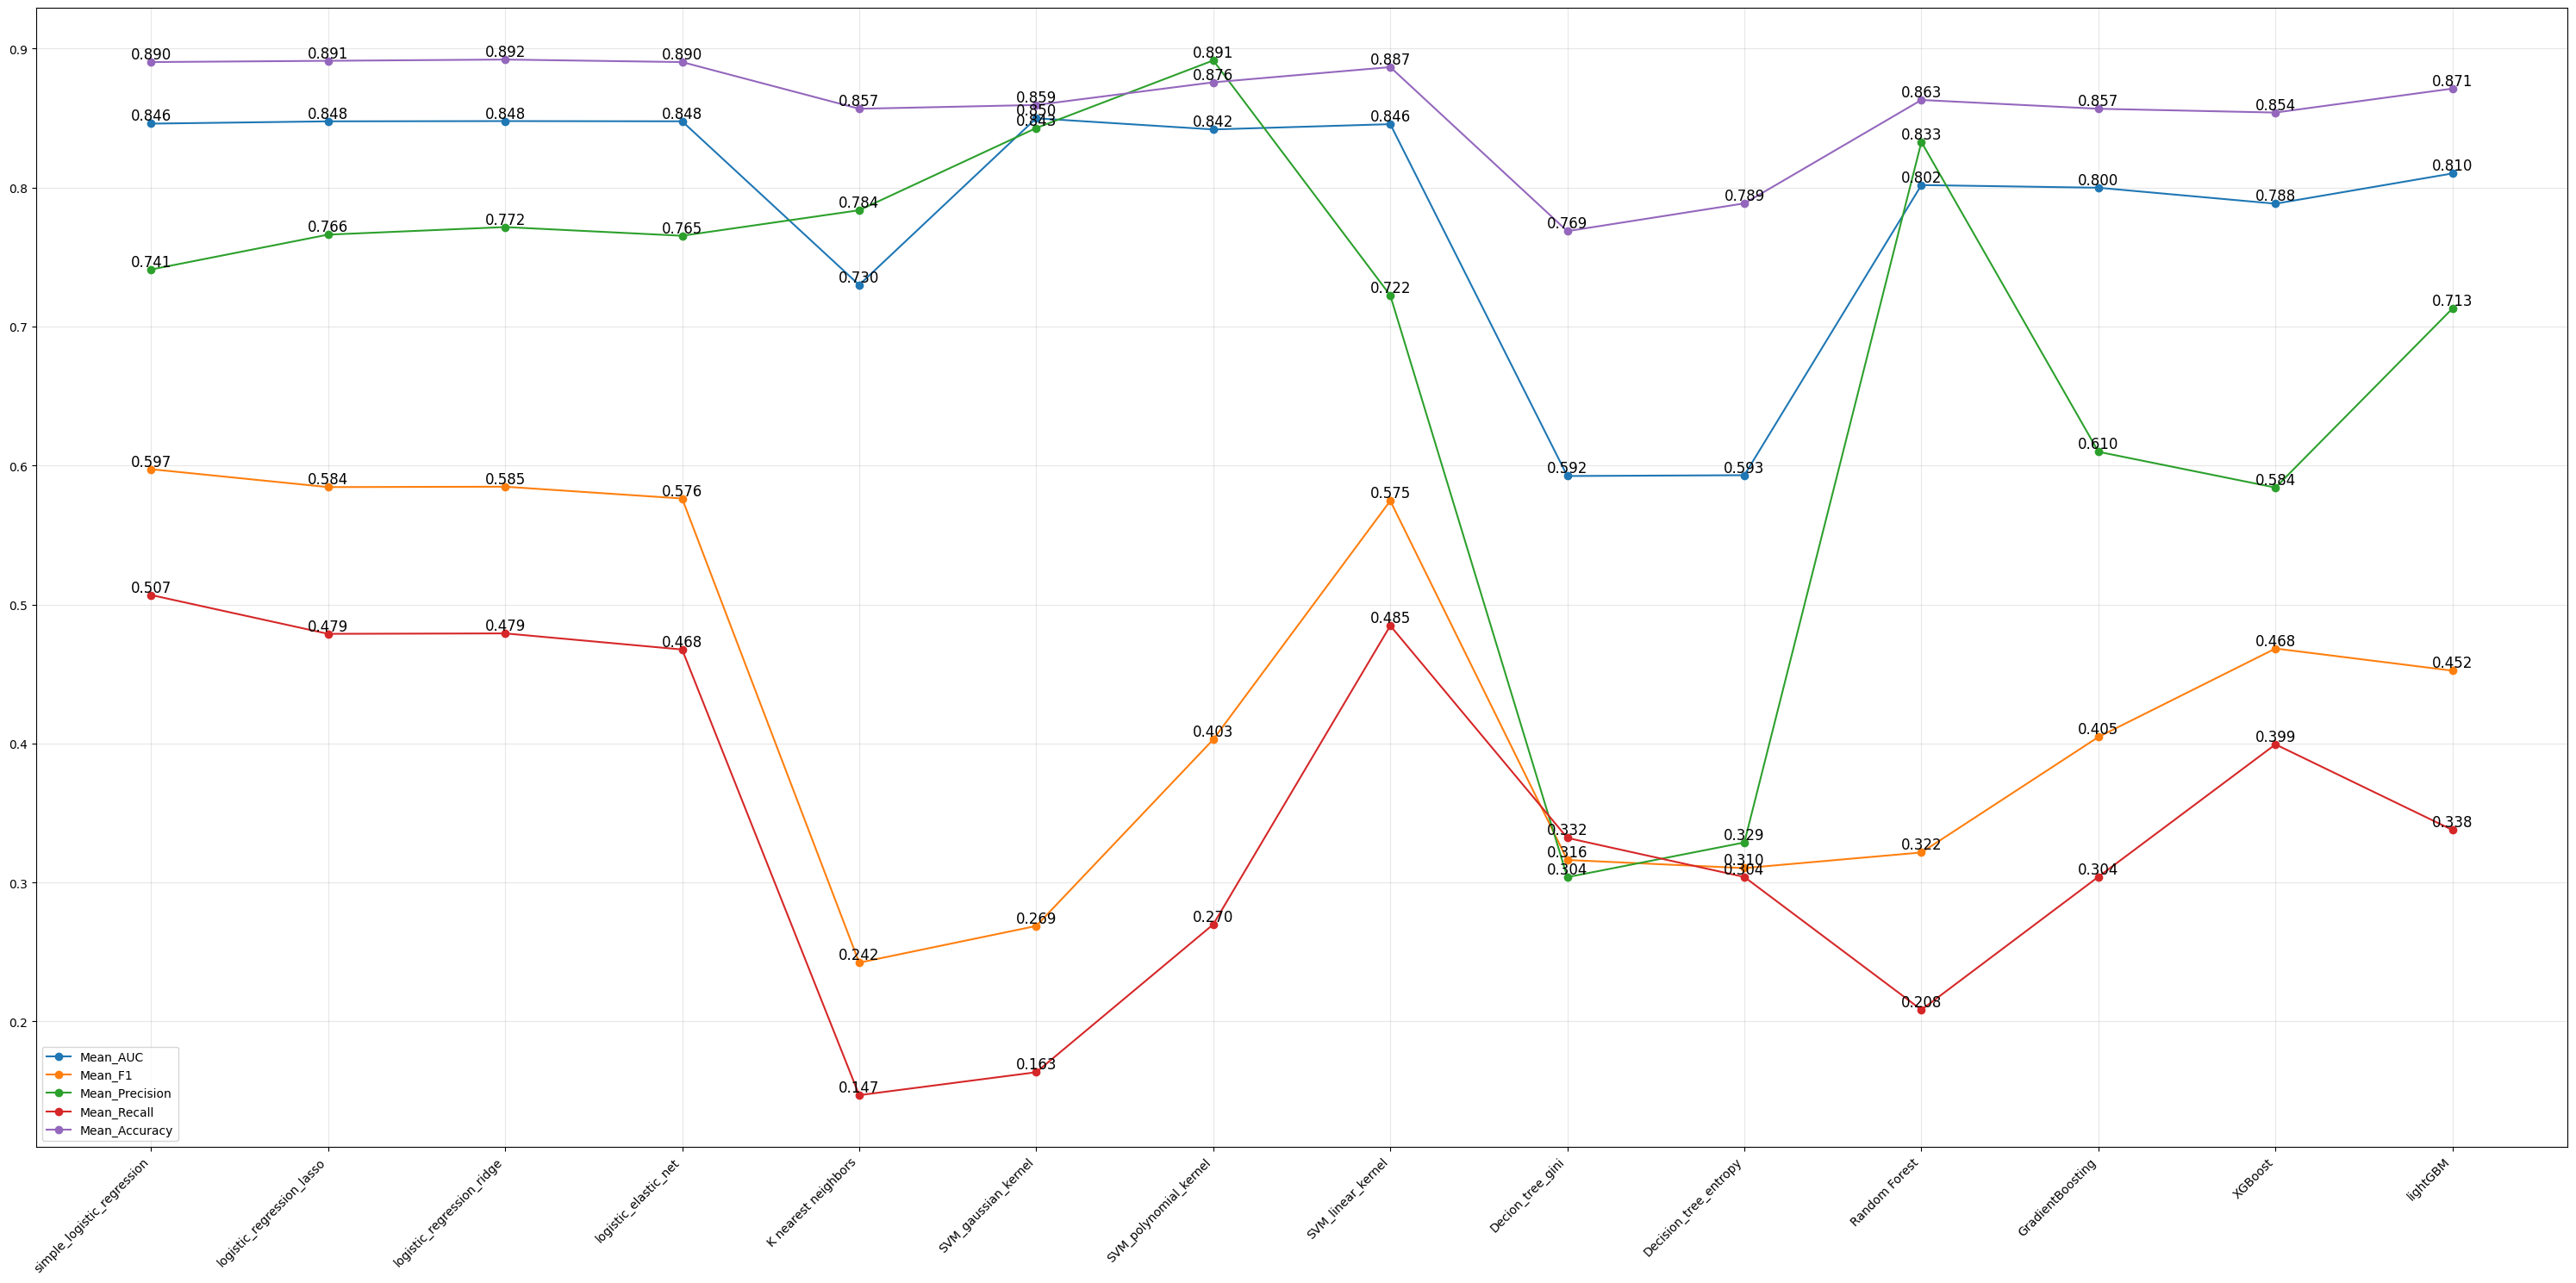

In [34]:
plt.figure(figsize=(30, 15))

models = results.index.tolist()
x = np.arange(len(models))

for col in results.columns:
    y = results[col].values
    plt.plot(x, y, marker='o', label=col)

    # 🔢 annotate values
    for i, val in enumerate(y):
        plt.text(
            i, val,
            f"{val:.3f}",
            fontsize=12,
            ha='center',
            va='bottom'
        )

plt.xticks(x, models, rotation=45, ha="right")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


All the metrics have some information to reflect , so we'll favorise models that excel in all of them  or the majority of them.

However we do care also more about AUC since, as mentionned before , the datset is clearly imbalaced but also about Recall ( among all the the employees that truly left, how much did we correctly predict ).

We do care a lot about recall, because it's really important to captivate all the employees before they churn 

With that being said we'll start with logistic regression , then Random Forest then SVM and last XGBoost

## Logistic Regression

In [48]:
Kfold = StratifiedKFold( n_splits=10, shuffle= True, random_state= 42)
cross_metrics = cross_validate (estimator= LogisticRegression(max_iter=1000),
                X= X_train, y = y_train, cv = Kfold,
                  scoring=['roc_auc','recall'], )

for metric in ['test_roc_auc', 'test_recall']:
    print (f'the average {metric.split('_')[-1]} for 10 splits is {cross_metrics[metric].mean() }')


the average auc for 10 splits is 0.8522529005368705
the average recall for 10 splits is 0.48692810457516333


Before this there is something really dangerous i didn't pay attention to : Data Leakage

    Scaling/log transforms must be learned only from training folds ( we did EDA like Standard scaling of numerical variables using the entire datasets :(( )

    Otherwise CV scores are optimistic

AUC ≈ 0.85 → good separability

Recall ≈ 0.49 → decision threshold issue, not necessarily model weakness

This means:

The model ranks employees well

But the default threshold (0.5) is too conservative

    GridSearch alone will not fully fix recall — threshold tuning will.

    GridSearchCV systematically evaluates multiple combinations of hyperparameters using cross-validation and selects the combination that optimizes a chosen metric.

What it is NOT

     It does not “learn better features” !!!!!!

     It does not fix a bad preprocessing pipeline !!!!!!

     It does not change model assumptions !!!!!!

GridSearch only answers:

“Given this model family and this preprocessing, which configuration generalizes best under my metric?”



Why no pipeline?

For this exploratory phase, I fixed preprocessing to focus on model behavior and hyperparameter effects. 

I’m aware this introduces optimistic bias, so for final validation or deployment I would encapsulate all steps in a pipeline.

In [49]:
# In grid search , here are the parameters that e care to explore, the rest will be kept as default 

parameters_grid = {
    "C": np.logspace(-3, 2, 10), # 10 evenly space values between 1e-3 and 100
    "class_weight": [None, "balanced"],
    "l1_ratio": [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]  # only used if elasticnet
}

best_performances = pd.DataFrame(columns = ['recall' , 'roc_auc', 'mse'])


startified_Kfold = StratifiedKFold(n_splits= 10, shuffle= True, random_state= 42)

grid = GridSearchCV(
    estimator = LogisticRegression(max_iter=1000, random_state=42, solver= 'saga', penalty = 'elasticnet', n_jobs=-1), # saga supports all penalties
    param_grid = parameters_grid,
    scoring = 'recall',
    cv = startified_Kfold,
    return_train_score = True # this allow us to unspect overfitting
)


In [50]:
grid

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...solver='saga')
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': array([1.0000...00000000e+02]), 'class_weight': [None, 'balanced'], 'l1_ratio': [0, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold a

In [51]:
grid.fit(X_train,y_train)

/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...solver='saga')
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': array([1.0000...00000000e+02]), 'class_weight': [None, 'balanced'], 'l1_ratio': [0, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold a

In [52]:
print('the combination of parameters that maximize our metric are ', grid.best_params_)
print('the recall value correspond to this optimization is ', grid.best_score_) #The mean cross-validated score on the TRAINING data, using the metric i chose (recall),averaged over all CV folds,for the best hyperparameter combination.

the combination of parameters that maximize our metric are  {'C': np.float64(0.046415888336127795), 'class_weight': 'balanced', 'l1_ratio': 0.1}
the recall value correspond to this optimization is  0.7637254901960786


In [53]:
# Now let's test our best model on test data 

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test) 
y_prob = best_model.predict_proba(X_test)[:,1]

recall_log_reg = recall_score(y_test,y_pred)
roc_auc_log_reg = roc_auc_score( y_test, y_prob)
mse_log_reg = mean_squared_error(y_test, y_pred)


#measure the performance
print(f'The recall, auc and mse  of best log_reg combination is is equal to {[recall_log_reg,roc_auc_log_reg,mse_log_reg]} ')

best_performances.loc['logistic regression'] = (recall_log_reg, roc_auc_log_reg, mse_log_reg)

The recall, auc and mse  of best log_reg combination is is equal to [0.6949152542372882, 0.793538478415885, 0.20380434782608695] 


In [54]:
print('The classifictaion report looks like \n', classification_report(y_test,y_pred))


The classifictaion report looks like 
               precision    recall  f1-score   support

           0       0.93      0.82      0.87       309
           1       0.42      0.69      0.52        59

    accuracy                           0.80       368
   macro avg       0.68      0.76      0.70       368
weighted avg       0.85      0.80      0.81       368



Text(50.722222222222214, 0.5, 'Truth')

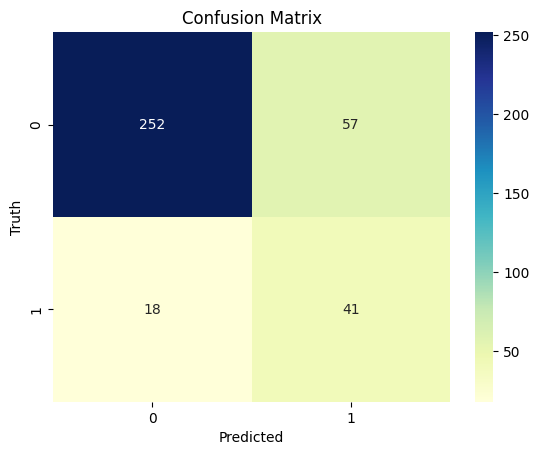

In [55]:
confusion_mat_log_reg = pd.DataFrame(confusion_matrix(y_test,y_pred))

plt.title('Confusion Matrix')
sns.heatmap(confusion_mat_log_reg, annot=True, cmap="YlGnBu" ,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Results analysis

As mentioned before,the grid search doesn't make the features better or the model itself better. However it does try all the given combinations of parameters and find the one that maximize the scoring metric we chose, in our case its recall 

on the validation, our best estimator had an average RECALL of 0.76 which is really impressing since what we use as a benchmark for logistic regression was 0.48

Tested on a dataset never seen before , we got a Recall = 0.69 , an AUC = 0.79 and an MSE = 0.2

With that being said, I had to dive a bit deeper into these metrics using a classification report.

the first two lines of the report shows the classical metrics depending on wether we're trying to predict the class 0 and 1.

We can see a huge difference between the performance when we're trying to predict class 0 (Non churn ) VS class 1 ( churn ), this difference was expected since dataset is imbalance and current employees are dominant ( 84% ). but the difference is still high 

The macro and micro average are good because the mediocre performance on predicting class 1 is hidden by the low percentage of this category 

Still, in the confusion matrix , we cans see that among the class 1 ( employees that left ) : 41 were correctly predicted but 18 were not ( False negatives ), which give us a false negative rate of 18/(18+41) = 0.3 !!!

### Threshold Tuning

the default threshold for deciding classes is 0.5.

Maybe this threshold is a bit harsh, let's try and lower it a bit and see its effect on the performances. 

Except we shouldn't fall in the trap of lowering it too much and thus predicting everything as churning and thus very little false negative 

But we'll be massacring the performance on the prediction of current employees, causing a very low accuracy and f1 score

In [56]:
# Let's try some threshold tuning 

threshold = 0.4 # example
y_pred_custom = (y_prob >= threshold).astype(int)

print("Recall (custom threshold): {:.3f}".format(recall_score(y_test, y_pred_custom)))
print('f1 score is {:.3f}'.format(f1_score(y_test,y_pred_custom)))
print('accuracy in this case is {:.3f}'.format(accuracy_score(y_test, y_pred_custom)))
print('-------------------')
print('the classification report is \n', classification_report(y_test,y_pred_custom))


Recall (custom threshold): 0.712
f1 score is 0.418
accuracy in this case is 0.682
-------------------
the classification report is 
               precision    recall  f1-score   support

           0       0.92      0.68      0.78       309
           1       0.30      0.71      0.42        59

    accuracy                           0.68       368
   macro avg       0.61      0.69      0.60       368
weighted avg       0.82      0.68      0.72       368



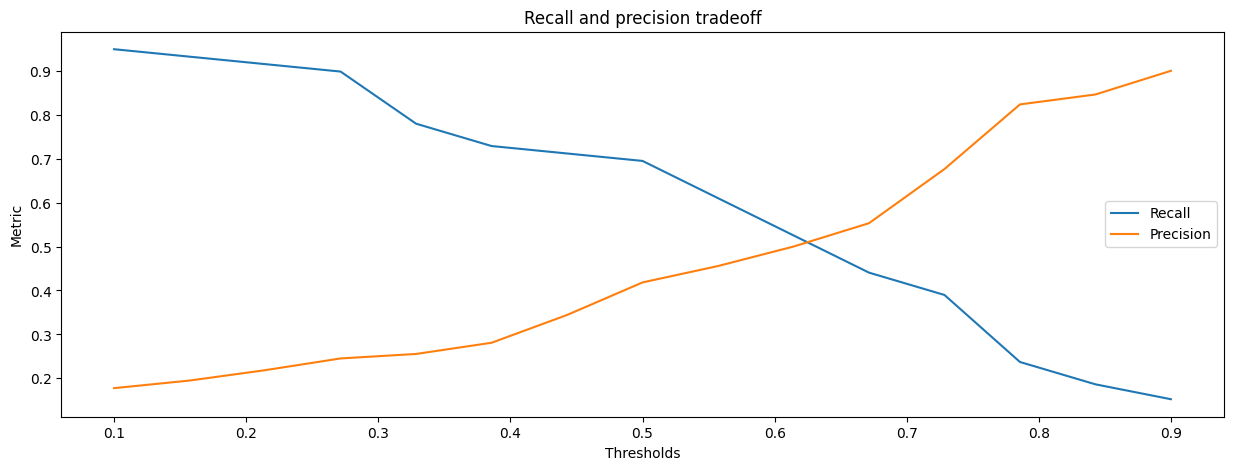

In [57]:
thresholds = np.linspace(0.1,0.9,15)
recalls_lg, precisions_lg = [], []
for threshold_ in thresholds :
    y_updated = (y_prob >= threshold_).astype(int)
    recalls_lg.append(recall_score(y_test, y_updated))
    precisions_lg.append(precision_score(y_test,y_updated))

plt.figure(figsize=(15,5))
plt.plot(thresholds, recalls_lg, label = 'Recall' )
plt.plot(thresholds,precisions_lg, label ='Precision')
plt.xlabel('Thresholds')
plt.ylabel('Metric')
plt.title('Recall and precision tradeoff')
plt.legend()
plt.show()

We actually want to maximize both the metrics, where maximizing recall means minimizing False negatives and maximizing precision means minimizing False positives

Although we do care more about false negatives since we can't afford losing precious employees, However this can't come at the cost of precision.

The question is : How much can we sacrifice of precision to gain in Recall ? To answer this we should have in had the cost of losing an employee VS the cost of giving an employee that wasn't intending to leave a raise/gifts to convince him of staying  

### Interpretation

The coefficients in logistic regression doesn't have the same interpretation as in linear regression as they represent log_odds



In [58]:
np.exp(best_model.intercept_)

array([11.55073047])

In [59]:
odds = pd.Series(
    np.exp(best_model.coef_[0]),
    index=X_train.columns
)

odds.sort_values(ascending=False)


OverTime                             2.653463
BusinessTravel                       1.721767
NumCompaniesWorked                   1.494435
MaritalStatus_Single                 1.475247
YearsSinceLastPromotion              1.442220
JobRole_Laboratory Technician        1.379191
DistanceFromHome                     1.290105
JobRole_Sales Executive              1.169585
Gender                               1.164237
JobRole_Sales Representative         1.162412
EducationField_Marketing             1.128352
EducationField_Technical Degree      1.107205
MonthlyRate                          1.043032
PerformanceRating                    1.015613
JobRole_Human Resources              1.000000
JobRole_Manager                      1.000000
JobRole_Manufacturing Director       0.989516
MaritalStatus_Married                0.989509
Education                            0.983444
EducationField_Medical               0.946200
HourlyRate                           0.929800
EducationField_Other              

intercept correspond to the baseline odds of attrition when all features are 0

for the rest of the coefficient ( they were stored in the same order as the columns )

A coefficient βj means:

    Change in log-odds for a one-unit increase in feature xj


np.exp(coef) > 1 → increases odds of attrition

np.exp(coef) < 1 → decreases odds

Magnitude matters only because I you scaled features ( 1 unit = standard deviation across all features)

---> Coefficient signs are always interpretable

---> Coefficient magnitudes are only comparable across features that are on comparable scales

Since our ordinal variables are not scaled, their coefficient magnitudes are not directly comparable to scaled numerical features.


Now compare:

Scaled numeric feature
    
    → +1 = 1 standard deviation

Ordinal feature

    → +1 = one category step (e.g. “Low → Medium”)

These “+1” changes do not mean the same thing.

## Random Forest

In [60]:
strat_Kfold_RF = StratifiedKFold(n_splits= 10, shuffle=True, random_state=42)

scoring_dict = {
    'recall_1' : 'recall', # we added one for the name of the metrics because it's the one of predicting class 1
    'precision_1' : 'precision',
    'roc_auc' : 'roc_auc'
}

cv_random_forest= cross_validate(
    estimator=RandomForestClassifier(n_estimators=200, random_state=42),
    X = X_train, y = y_train,
    cv = strat_Kfold_RF ,
    scoring = scoring_dict
)


for metric in ['test_roc_auc', 'test_recall_1','test_precision_1']:
    print (f'the average {metric.split('_')[-1]} for 10 splits is {cv_random_forest[metric].mean() }')

the average auc for 10 splits is 0.8186125739839337
the average 1 for 10 splits is 0.16895424836601308
the average 1 for 10 splits is 0.8383333333333333


In the example above, we can see the performance of the random forest algorithm on our data with default parameters.

This is textbook Random Forest behavior on imbalanced data with default settings. Why?

    RF optimizes node purity, not recall

    Default threshold = 0.5

    No class weighting by default

    Trees are very confident → few positive predictions

So low recall ≠ weak model

The recall is awful ( 0.16 )!!!! , meaning on average , we catch only 16% of leavers among all the employees that were actually intending to leave.

But to cut the model some slack we didn't tune a lot of parameters that can clearly improve the model's performance specially that we're dealing with an imbalanced dataset

In [69]:
parameters_RF = {
    "max_depth": [None, 5, 10, 20], #The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split 
    "min_samples_split": [2, 10, 30], #The minimum number of samples required to split an internal node
    "min_samples_leaf": [1, 5, 10], #The minimum number of samples required to be at a leaf node
    "max_features": [None, "sqrt", "log2"], #The number of features to consider when looking for the best split, None corresponds to considering all features 
    "class_weight": [None, "balanced"]
}


gridsearch_RF =GridSearchCV(
    estimator= RandomForestClassifier(n_estimators=200, n_jobs=4, bootstrap=True, random_state=67), # six seveeeeeeeeeeeeeeen
    param_grid=parameters_RF,
    scoring= 'recall',
    cv= strat_Kfold_RF,
    verbose = 10
)

gridsearch_RF

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=67)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'class_weight': [None, 'balanced'], 'max_depth': [None, 5, ...], 'max_features': [None, 'sqrt', ...], 'min_samples_leaf': [1, 5, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >

In [70]:
gridsearch_RF.fit(X_train,y_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV 1/10; 1/216] START class_weight=None, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2
[CV 1/10; 1/216] END class_weight=None, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=0.222 total time=   0.7s
[CV 2/10; 1/216] START class_weight=None, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2
[CV 2/10; 1/216] END class_weight=None, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=0.333 total time=   0.7s
[CV 3/10; 1/216] START class_weight=None, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2
[CV 3/10; 1/216] END class_weight=None, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=0.235 total time=   0.7s
[CV 4/10; 1/216] START class_weight=None, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2
[CV 4/10; 1/216] END cl

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=67)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'class_weight': [None, 'balanced'], 'max_depth': [None, 5, ...], 'max_features': [None, 'sqrt', ...], 'min_samples_leaf': [1, 5, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >

In [85]:
print( f'The recall coreespong to random forest using this combination is {gridsearch_RF.best_score_}')

The recall coreespong to random forest using this combination is 0.5111111111111112


In [72]:
best_RF = gridsearch_RF.best_estimator_

y_precicted_rf = best_RF.predict(X_test)
y_proba_RF = best_RF.predict_proba(X_test)[:,1]

recall_RF = recall_score(y_test,y_precicted_rf)
roc_auc_RF = roc_auc_score( y_test, y_proba_RF)
mse_RF = mean_squared_error(y_test, y_precicted_rf)

print(f'The recall, auc and mse  of best log_reg combination is is equal to {[recall_RF, roc_auc_RF, mse_RF]} ')

best_performances.loc['random forest'] = (recall_RF, roc_auc_RF, mse_RF)

The recall, auc and mse  of best log_reg combination is is equal to [0.4406779661016949, 0.771323569743843, 0.1875] 


In [87]:
print('The classifictaion report looks like \n', classification_report(y_test,y_precicted_rf))


The classifictaion report looks like 
               precision    recall  f1-score   support

           0       0.89      0.88      0.89       309
           1       0.42      0.44      0.43        59

    accuracy                           0.81       368
   macro avg       0.66      0.66      0.66       368
weighted avg       0.82      0.81      0.81       368



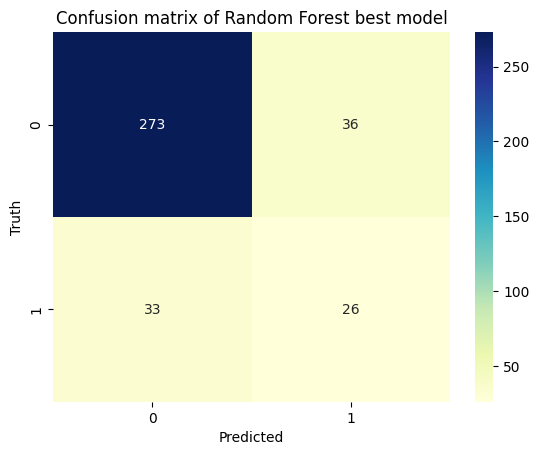

In [83]:
confusion_matrix_rf = pd.DataFrame(confusion_matrix(y_test, y_precicted_rf))

sns.heatmap(confusion_matrix_rf , annot= True , cmap='YlGnBu', fmt ='g')
plt.title('Confusion matrix of Random Forest best model')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [86]:
print( f'For random forest the best combination of params is {gridsearch_RF.best_params_} ')


For random forest the best combination of params is {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 30} 


### Result Analysis

The gridsearch did actually help us boost our metrics, we went from a recall = 0.17 using just the default values on every parameter to a recall of 0.51 on the validation on  average 

Tested on a dataset never seen before , we got a Recall = 0.44 , an AUC = 0.77 and an MSE = 0.18

For auc and recall , both of them were lower than the best estimator of logistic regression , approxiamtly the same auc but a huge difference when it comes to recall.

On the other hand , we got ourselves a slightly lower mse on the test set.

the first two lines of the report shows the classical metrics depending on wether we're trying to predict the class 0 and 1.

We can see a huge difference between the performance when we're trying to predict class 0 (Non churn ) VS class 1 ( churn ), this difference was expected since dataset is imbalance and current employees are dominant ( 84% ). but the difference is still high 

Although the best estimator has 'balanced' in the parameter class_weight that takes into consideration the ombalance and adjusts the splitting by taking into consideration the different proportion of the two classes.

Still, in the confusion matrix , we cans see that among the class 1 ( employees that left ) : 26 were correctly predicted but 33 were not ( False negatives ), which when it comes to employees who churn, we make more mistakes that predicting that they will stay than actually finding out they're leaving

### Threshold Tuning 

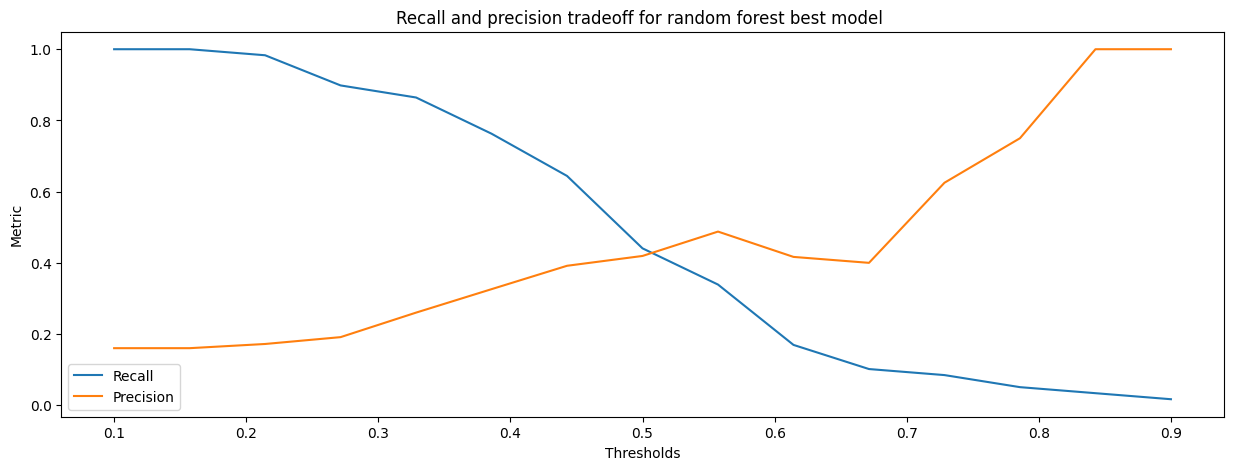

In [90]:
#we already have a list of thresholds from the study on logistic regression

recalls_rf, precisions_rf = [], []
for threshold_ in thresholds :
    y_updated = (y_proba_RF >= threshold_).astype(int)
    recalls_rf.append(recall_score(y_test, y_updated))
    precisions_rf.append(precision_score(y_test,y_updated))

plt.figure(figsize=(15,5))
plt.plot(thresholds, recalls_rf, label = 'Recall' )
plt.plot(thresholds,precisions_rf, label ='Precision')
plt.xlabel('Thresholds')
plt.ylabel('Metric')
plt.title('Recall and precision tradeoff for random forest best model ')
plt.legend()
plt.show()

Same on what was said before, we can clearly see the trade off between the two of the metrics depending on the threshold ( the bigger the threshold , the more we are insisting and prudent on deciding if a person is churning , --> less people decided as churned  unitil we decide no one is churninng --> this will cause a recall of 0 because we miss all the churing ones but a high precision because no false positives)

A decision of the threshold is strongly depending on the cost of each error , until then we'll keep a threshold of 0.5

### Feature importance 

For a feature j:

Importance = total reduction in impurity (Gini or entropy) caused by splits using feature j, averaged over all trees.

    High importance → feature is frequently used and reduces uncertainty

    Low importance → feature rarely helps splitting

Importance is relative, not absolute

    No direction (no “positive” or “negative” effect)

You cannot say how the feature affects attrition, only that it matters.

Important limitations (must know)

Biased toward:

    continuous variables

    high-cardinality features

    Correlated features split importance

-->Not causal / Not comparable to LR coefficients

:)  Better alternative (recommended) : Permutation importance !!!!!!!!!!!!

    Measure performance drop when a feature is randomly shuffled.

This answers: “How much does the model rely on this feature?” Much more reliable for interpretation.

For one feature Xj:

Measure baseline performance (e.g. recall) on a validation set

Randomly shuffle values of Xj across samples
    
    → destroys its information

Measure performance again

    Performance drop = importance of xj
	

In [97]:
importances = best_RF.feature_importances_

features_RF = pd.Series(importances, index = X_train.columns).sort_values(ascending=False)

features_RF.head(5)



OverTime                0.098565
TotalWorkingYears       0.096400
Age                     0.092090
MonthlyIncome           0.089755
YearsWithCurrManager    0.077709
dtype: float64

As mentioned before , the results are not signed, so we don't now if each feature is helping us to decide if the feature is responsible for an employee churning or staying.

however in term of deciding how they contribute so minimizing the impurity during splits and separating samples ( churn vs staying), the three that comes first are :

    Overtime

    Total Working Years

    Age

I suspect that we would have gotten better result if we did not adjust the numerical variables ( scalling + fixing the skewness), but we'll deal with that later 

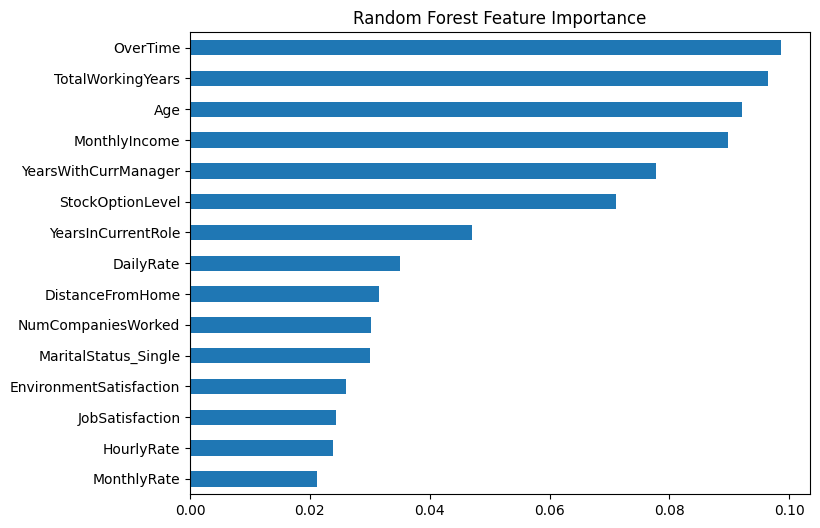

In [100]:
plt.figure(figsize=(8, 6))
features_RF.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.show()


## SVM

on the comparaison earlier between the different models we saw that svm as a classifier has some really promising results specially for linear kernel

for this, we decided to explore this model as well and see if we can can push it to surpass linear regression

In [111]:
Kfold_svm = StratifiedKFold(n_splits=10, shuffle= True, random_state=42)

model_SVM = SVC(kernel='linear' , class_weight='balanced')

crossV_SVC = cross_validate(
    estimator=model_SVM,
    X=X_train, y =y_train,
    cv= Kfold_svm,
    scoring= ['roc_auc', 'recall', 'precision', 'f1']
                            )

for key, value in crossV_SVC.items():
    print(f'The mean value for {key} on validation is {value.mean()}')

The mean value for fit_time on validation is 0.07581758499145508
The mean value for score_time on validation is 0.014889287948608398
The mean value for test_roc_auc on validation is 0.846675650157211
The mean value for test_recall on validation is 0.7522875816993464
The mean value for test_precision on validation is 0.43406034863974235
The mean value for test_f1 on validation is 0.547904934808301


From what we can see above , the recall is pretty satisfying before any parameter tuning. 

We know that regarding the kernel the score of the metrics reach their max when its 'linear', however for the benefit of the doubt we'll try other ones when doing some hyperparameter tuning 



In [142]:
#the kfold is already declared

parametersgrid_SVC = {
    'kernel' : ['linear', 'rbf','poly'],
    'C': np.linspace(0.1, 20,10) , #     A higher C value makes the model aim for fewer misclassifications by using a smaller margin, while a lower C allows more misclassifications with a wider margin.
    'class_weight': [None , 'balanced'],
    'gamma': ['scale', 'auto'], # valable only for poly and rbf
    'degree' : [2,3,4,5]
}

grid_search_svc = GridSearchCV(
    estimator= SVC(random_state=42),
    param_grid= parametersgrid_SVC,
    scoring = 'recall',
    verbose = 2,
    cv = Kfold_svm
)

grid_search_svc

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC(random_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': array([ 0.1 ... 20. ]), 'class_weight': [None, 'balanced'], 'degree': [2, 3, ...], 'gamma': ['scale', 'auto'], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for 

In [143]:
grid_search_svc.fit(X_train, y_train)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.1s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1,

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC(random_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': array([ 0.1 ... 20. ]), 'class_weight': [None, 'balanced'], 'degree': [2, 3, ...], 'gamma': ['scale', 'auto'], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for 

In [146]:
print('the average best performance on validation led to a recall of ', grid_search_svc.best_score_)
print('And the params responsable for this are ', grid_search_svc.best_params_)

the average best performance on validation led to a recall of  0.7915032679738563
And the params responsable for this are  {'C': np.float64(0.1), 'class_weight': 'balanced', 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}


In [154]:
best_svm = grid_search_svc.best_estimator_

best_svm.probability= True
best_svm.fit(X=X_train, y = y_train)
# normally we don't need to ddo a fit again 

y_predicted_svm =  best_svm.predict(X_test)
y_proba_SVM = best_svm.predict_proba(X_test)[:,1]

auc_svm = roc_auc_score(y_test, y_proba_SVM)
recall_svm = recall_score(y_test,y_predicted_svm)
precision_svm = precision_score(y_test,y_predicted_svm)
mse_svm = mean_squared_error(y_test, y_predicted_svm)

print(f''' On the test datset , the performance of the best svm is given by :
      recall = {recall_svm}
      precison = {precision_svm}
      auc = {auc_svm}''')


 On the test datset , the performance of the best svm is given by :
      recall = 0.6440677966101694
      precison = 0.3275862068965517
      auc = 0.7367121935165377


In [157]:
best_performances.loc['SVM'] = (recall_svm, auc_svm, mse_svm)

print('The classification report of the svm model after gridSearch is \n', classification_report(y_test,y_predicted_svm))

The classification report of the svm model after gridSearch is 
               precision    recall  f1-score   support

           0       0.92      0.75      0.82       309
           1       0.33      0.64      0.43        59

    accuracy                           0.73       368
   macro avg       0.62      0.70      0.63       368
weighted avg       0.82      0.73      0.76       368



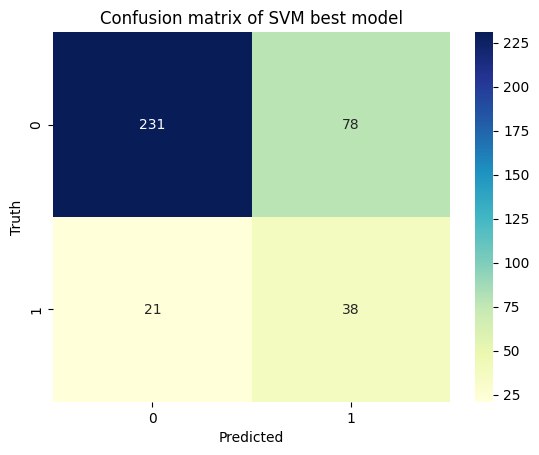

In [159]:
confusion_matrix_svm = pd.DataFrame(confusion_matrix(y_test, y_predicted_svm))

sns.heatmap(confusion_matrix_svm , annot= True , cmap='YlGnBu', fmt ='g')
plt.title('Confusion matrix of SVM best model')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Result Analysis

For SVM, it is very famous as a classification model, despite being old, it has always proved his efficiency against complex and high dimensional datasets.

In the very first beginning, svm showed some promisisng results using a very naive model by only precising a linear kernel ( the default is rbf ), and adding class_weight= 'balanced' to take into consideration the imbalanced datased and add more penalty on missclassified points from the minority classes. The result was an average recall of 0.75 

With such good performance right from the beginning , i decided to dive deep and explore a combination of parameters that would optimize the performance inclusing a variety of kernel types , a wide range of 'C' values to test hard vs soft margins and different values of gamma  ( rbf ) and degree ( polynomial )

To my surprise the best perfomance corresponds to the following combination of params:

    C=0.1 a very low C corresponds to a wider margin 

    'kernel'= 'poly' for no particcular reason i was expecting it to be rbf 

    'class_weight': 'balanced' as expected

    'degree': 5 as it is the highest degree i allowed during gridsearch, also the more complex the model, the more precise it is but also the more tendencies it has to overfit

Regarding the performance of the models, it does actually perform well on the test dataset , the performance is surely lower than the avg training dataset since it's data the model has never seen before.

    RECALL : 0.64

    AUC : 0.74

    PRECISION : 0.33

Again similar to all the previous models, when we take a look at the classification report, the models excels at predicting the current employers instead of of the churning ones since the they are a minority, however the recall is comparable which is satisfying.

The confusion matrix shows as an  important thing which is : the high recall is justified by the fact that we catch 38 out of 59 churning person, however regarding the current employees that does not intend to leave wemake a lot of mistakes predicting 78 of them as attrition ( out of 309 ) which is really high and justify the low value of the precision !!!

In the cas of svm and the following model XGBOOST , i won't do a threshold tuning  because i don't quit see the imporatnce unless it's the final model i'm going to keep 

## XGBOOST

XGboost had a poor avg performance at the first try but due to its reputation, i decided to give him the benefit of the doubt 

## Conclusion

In [150]:
best_performances.to_csv('best_performances.csv')